In [1]:
# install library statsmodels
!pip install statsmodels==0.12.2

In [2]:
# impor library standard
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.proportion import power_proportions_2indep, test_proportions_2indep
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# A. Landing Page Case Study - All Datset Analysis

The Business Development team is conducting an experiment on the company's website to test the effectiveness of the new landing page.
As a BI analyst they asked our opinion if the landing page should be adopted or not. We must conduct an A/B testing based on the given dataset and perform statistical tests. The result and decision will strongly affect the implementation of the new landing page.

## 1. Designing experiment

### Formulating a hypothesis
Using conversion rate notation as a probability in the binomial distribution, the hypothesis can be formulated as follows:

$H_0$: conversion rate for new design and old design is the same, $ p_A = p_B $

$H_1$: conversion rate for new design and old design page is the different, $ p_A \neq p_B $

With confidence level is 95% or alpha is 5%, if the probability of observing a result as extreme or more (p-value) is lower than alpha, then $H_0$ is rejected.

### Choosing the variable

There are two groups in this experiment:
- A control group - They'll be shown the old design
- A treatment group - They'll be shown the new design

This will be Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality. By having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:
- 0 : new landing page did not affect user conversion
- 1 : new landing page affect user conversion
This way, we can easily calculate the mean for each group to get the conversion rate of each design.

## 2. Collecting and preparing the data

- Read the data into a pandas DataFrame
- Check and clean the data as needed

In [3]:
df = pd.read_csv('ab_testing.csv', sep=';', parse_dates=True)
df

,user_id,timestamp,group,landing_page,converted
0,851104,21/01/2017 22:11,control,old_page,0
1,804228,12/01/2017 08:01,control,old_page,0
2,661590,11/01/2017 16:55,treatment,new_page,0
3,853541,08/01/2017 18:28,treatment,new_page,0
4,864975,21/01/2017 01:52,control,old_page,1
...,...,...,...,...,...
294473,751197,03/01/2017 22:28,control,old_page,0
294474,945152,12/01/2017 00:51,control,old_page,0
294475,734608,22/01/2017 11:45,control,old_page,0
294476,697314,15/01/2017 01:20,control,old_page,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :

- user_id : Sample of A/B testing. The list is random
- timestamp : Timestamp where the A/B testing was taken
- group : Treatment and Control
- landing_page : Old Page and New Page. New Page for Treatment, Old Page for Control.
- converted : Binary 0 and 1, 
              0 = not converted - new landing page did not affect user conversion, 
              1 = converted - new landing page affect user conversion.

In [5]:
# To convert column timestamp to datetime format
df['timestamp'] =  pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [6]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
# To calculate current data set entries
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 294478 entries


In [8]:
# To make sure there are no users that have been sampled multiple times.
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [9]:
# To remove users that appear more than once from the DataFrame to avoid sampling the same users twice.

users_to_drop = session_counts[session_counts > 1].index

day_all = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day_all.shape[0]} entries')

The updated dataset now has 286690 entries


## 3. Visualising the results

In [10]:
# To calculate some basic statistics to get an idea of what our samples look like.
conversion_rates = day_all.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


Based on calculation above, conversion rate between control group (old page) and treatment (new page) are similiar about 11.9 - 12 %. We can see the graph below to show the better comparison.  

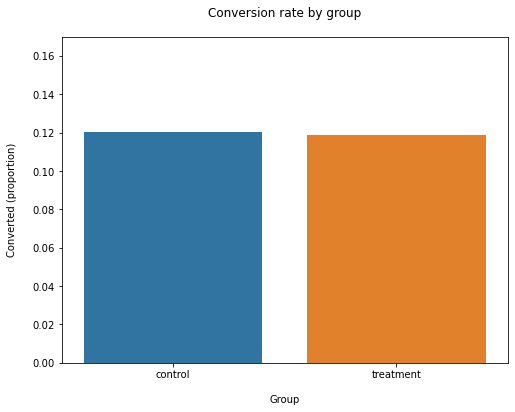

In [11]:
# To Plotting the data will make these results easier to grasp
plt.figure(figsize=(8,6))

sns.barplot(x=day_all['group'], y=day_all['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## 4. Testing The Hypothesis

We have a very large sample then we can use the normal approximation for calculating our -value (i.e. z-test).

In [12]:
# To calculate -value (i.e. z-test) using normal approximation with very large sample
control_results = day_all[day_all['group'] == 'control']['converted']
treatment_results = day_all[day_all['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [0.117, 0.120]


## 5. Drawing Conclusion

Since our p-value is 0.232, above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that new design did not perform significantly different than the old design.

If we look at the confidence interval for the treatment group - new landing page design ([0.117, 0.120], or 11.7-12%) and compare to the control group - old landing page design ([0.118, 0.122], or 11.8-12.2%), we notice that there is no significant improvement of conversion rate for new design. This is further proof that our new design is not likely to be an improvement on our old design.

# B. Landing Page Case Study - Daily Datset Analysis

In this section, we will have analysis based on daily statically result. We do same thing for designing experiment like previous section in daily basis.

### Collecting and preparing the data

In [13]:
df = pd.read_csv('ab_testing.csv', sep=';', parse_dates=True)
df

,user_id,timestamp,group,landing_page,converted
0,851104,21/01/2017 22:11,control,old_page,0
1,804228,12/01/2017 08:01,control,old_page,0
2,661590,11/01/2017 16:55,treatment,new_page,0
3,853541,08/01/2017 18:28,treatment,new_page,0
4,864975,21/01/2017 01:52,control,old_page,1
...,...,...,...,...,...
294473,751197,03/01/2017 22:28,control,old_page,0
294474,945152,12/01/2017 00:51,control,old_page,0
294475,734608,22/01/2017 11:45,control,old_page,0
294476,697314,15/01/2017 01:20,control,old_page,0


In [14]:
# To convert column timestamp to datetime format
df['timestamp'] =  pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


## Day 1 Analysis

In [15]:
# To filter data based on spesific date
start_date = '2017-01-02 00:00:00'
end_date = '2017-01-02 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day01 = df.loc[mask]
day01

,user_id,timestamp,group,landing_page,converted
39,870163,2017-01-02 21:33:00,treatment,new_page,0
118,675405,2017-01-02 18:36:00,control,old_page,0
174,923958,2017-01-02 22:27:00,control,old_page,0
211,817695,2017-01-02 14:27:00,control,old_page,0
288,908149,2017-01-02 15:36:00,control,old_page,0
...,...,...,...,...,...
294394,742454,2017-01-02 15:16:00,treatment,new_page,0
294416,865958,2017-01-02 18:05:00,treatment,new_page,0
294418,746102,2017-01-02 18:16:00,control,old_page,0
294456,679096,2017-01-02 16:43:00,treatment,new_page,0


In [16]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day01['group'], day01['landing_page'])

landing_page,new_page,old_page
group,,
control,35,2859
treatment,2853,36


In [17]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day01.shape[0]} entries')

session_counts = day01['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day01 = day01[~day01['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day01.shape[0]} entries')

The updated dataset now has 5783 entries
There are 0 users that appear multiple times in the dataset
The updated dataset now has 5783 entries


In [18]:
# To calculate some basic statistics to get an idea of what our samples look like.
conversion_rates = day01.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.125,0.331,0.006
treatment,0.120,0.325,0.006


In [19]:
# To calculate -value (i.e. z-test) using normal approximation with very large sample
control_results = day01[day01['group'] == 'control']['converted']
treatment_results = day01[day01['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.54
p-value: 0.592
ci 95% for control group: [0.113, 0.137]
ci 95% for treatment group: [0.109, 0.132]


## Day 2 Analysis

In [20]:
# To filter data based on spesific date
start_date = '2017-01-03 00:00:00'
end_date = '2017-01-03 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day02 = df.loc[mask]
day02

,user_id,timestamp,group,landing_page,converted
38,728086,2017-01-03 17:07:00,treatment,new_page,0
41,739414,2017-01-03 13:25:00,treatment,new_page,0
57,714733,2017-01-03 08:22:00,control,old_page,0
72,817936,2017-01-03 20:00:00,treatment,new_page,0
84,778778,2017-01-03 19:34:00,control,old_page,0
...,...,...,...,...,...
294413,757420,2017-01-03 15:20:00,treatment,new_page,0
294427,774769,2017-01-03 06:01:00,treatment,new_page,0
294437,676732,2017-01-03 23:06:00,treatment,new_page,0
294462,677163,2017-01-03 19:41:00,treatment,new_page,0


In [21]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day02['group'], day02['landing_page'])

landing_page,new_page,old_page
group,,
control,94,6590
treatment,6618,92


In [22]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day02.shape[0]} entries')

session_counts = day02['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day02 = day02[~day02['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day02.shape[0]} entries')

The updated dataset now has 13394 entries
There are 7 users that appear multiple times in the dataset
The updated dataset now has 13380 entries


In [23]:
conversion_rates = day02.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.113,0.317,0.004
treatment,0.114,0.317,0.004


In [24]:
control_results = day02[day02['group'] == 'control']['converted']
treatment_results = day02[day02['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.04
p-value: 0.965
ci 95% for control group: [0.106, 0.121]
ci 95% for treatment group: [0.106, 0.121]


## Day 3 Analysis

In [25]:
# To filter data based on spesific date
start_date = '2017-01-04 00:00:00'
end_date = '2017-01-04 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day03 = df.loc[mask]
day03

,user_id,timestamp,group,landing_page,converted
8,817355,2017-01-04 17:58:00,treatment,new_page,1
86,764145,2017-01-04 00:18:00,treatment,new_page,0
96,894540,2017-01-04 03:38:00,treatment,new_page,0
169,714092,2017-01-04 22:23:00,treatment,new_page,0
205,853881,2017-01-04 23:53:00,control,old_page,0
...,...,...,...,...,...
294389,886877,2017-01-04 08:34:00,control,old_page,0
294391,694647,2017-01-04 13:57:00,control,old_page,0
294409,659902,2017-01-04 00:12:00,control,old_page,0
294439,862218,2017-01-04 10:43:00,treatment,new_page,0


In [26]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day03['group'], day03['landing_page'])

landing_page,new_page,old_page
group,,
control,77,6577
treatment,6541,88


In [27]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day03.shape[0]} entries')

session_counts = day03['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day03 = day03[~day03['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day03.shape[0]} entries')

The updated dataset now has 13283 entries
There are 10 users that appear multiple times in the dataset
The updated dataset now has 13263 entries


In [28]:
conversion_rates = day03.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.327,0.004
treatment,0.117,0.321,0.004


In [29]:
control_results = day03[day03['group'] == 'control']['converted']
treatment_results = day03[day03['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.93
p-value: 0.351
ci 95% for control group: [0.114, 0.130]
ci 95% for treatment group: [0.109, 0.124]


## Day 4 Analysis

In [30]:
# To filter data based on spesific date
start_date = '2017-01-05 00:00:00'
end_date = '2017-01-05 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day04 = df.loc[mask]
day04

,user_id,timestamp,group,landing_page,converted
26,892356,2017-01-05 09:35:00,treatment,new_page,1
31,826115,2017-01-05 11:27:00,treatment,new_page,0
32,875124,2017-01-05 15:39:00,treatment,new_page,1
44,939593,2017-01-05 09:15:00,control,old_page,0
50,670941,2017-01-05 08:16:00,control,old_page,0
...,...,...,...,...,...
294351,812915,2017-01-05 23:18:00,treatment,new_page,0
294359,665781,2017-01-05 04:05:00,control,old_page,0
294360,782196,2017-01-05 06:05:00,control,old_page,0
294397,932246,2017-01-05 15:48:00,treatment,new_page,0


In [31]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day04['group'], day04['landing_page'])

landing_page,new_page,old_page
group,,
control,111,6428
treatment,6505,81


In [32]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day04.shape[0]} entries')

session_counts = day04['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day04 = day04[~day04['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day04.shape[0]} entries')

The updated dataset now has 13125 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13109 entries


In [33]:
conversion_rates = day04.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.328,0.004
treatment,0.115,0.319,0.004


In [34]:
control_results = day04[day04['group'] == 'control']['converted']
treatment_results = day04[day04['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.29
p-value: 0.197
ci 95% for control group: [0.115, 0.130]
ci 95% for treatment group: [0.107, 0.123]


## Day 5 Analysis

In [137]:
# To filter data based on spesific date
start_date = '2017-01-06 00:00:00'
end_date = '2017-01-06 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day05 = df.loc[mask]
day05

,user_id,timestamp,group,landing_page,converted
29,736159,2017-01-06 01:50:00,treatment,new_page,0
104,734232,2017-01-06 11:25:00,treatment,new_page,0
120,919227,2017-01-06 08:13:00,control,old_page,0
126,903977,2017-01-06 18:48:00,treatment,new_page,1
139,896902,2017-01-06 01:33:00,treatment,new_page,0
...,...,...,...,...,...
294253,886135,2017-01-06 12:49:00,control,new_page,0
294287,788122,2017-01-06 00:31:00,treatment,new_page,0
294367,810937,2017-01-06 19:21:00,control,old_page,0
294422,849625,2017-01-06 17:54:00,treatment,new_page,0


In [138]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day05['group'], day05['landing_page'])

landing_page,new_page,old_page
group,,
control,78,6606
treatment,6747,97


In [139]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day05.shape[0]} entries')

session_counts = day05['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day05 = day05[~day05['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day05.shape[0]} entries')

The updated dataset now has 13528 entries
There are 9 users that appear multiple times in the dataset
The updated dataset now has 13510 entries


In [140]:
conversion_rates = day05.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.117,0.321,0.004
treatment,0.124,0.329,0.004


In [141]:
control_results = day05[day05['group'] == 'control']['converted']
treatment_results = day05[day05['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.28
p-value: 0.202
ci 95% for control group: [0.109, 0.124]
ci 95% for treatment group: [0.116, 0.131]


## Day 6 Analysis

In [40]:
# To filter data based on spesific date
start_date = '2017-01-07 00:00:00'
end_date = '2017-01-07 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day06 = df.loc[mask]
day06

,user_id,timestamp,group,landing_page,converted
33,931013,2017-01-07 03:23:00,treatment,new_page,0
65,742910,2017-01-07 11:15:00,treatment,new_page,0
77,689369,2017-01-07 19:27:00,control,old_page,0
79,819394,2017-01-07 09:27:00,treatment,new_page,0
88,792499,2017-01-07 02:30:00,treatment,new_page,1
...,...,...,...,...,...
294387,871941,2017-01-07 09:48:00,control,old_page,0
294401,922470,2017-01-07 13:50:00,treatment,new_page,0
294433,641244,2017-01-07 16:57:00,treatment,new_page,0
294435,886374,2017-01-07 13:43:00,treatment,new_page,0


In [41]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day06['group'], day06['landing_page'])

landing_page,new_page,old_page
group,,
control,74,6604
treatment,6608,94


In [42]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day05.shape[0]} entries')

session_counts = day06['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day06 = day06[~day06['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day06.shape[0]} entries')

The updated dataset now has 13510 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13364 entries


In [43]:
conversion_rates = day06.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.004
treatment,0.116,0.320,0.004


In [44]:
control_results = day06[day06['group'] == 'control']['converted']
treatment_results = day06[day06['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.79
p-value: 0.431
ci 95% for control group: [0.113, 0.128]
ci 95% for treatment group: [0.108, 0.124]


## Day 7 Analysis

In [45]:
# To filter data based on spesific date
start_date = '2017-01-08 00:00:00'
end_date = '2017-01-08 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day07 = df.loc[mask]
day07

,user_id,timestamp,group,landing_page,converted
3,853541,2017-01-08 18:28:00,treatment,new_page,0
17,888545,2017-01-08 06:37:00,treatment,new_page,1
43,862225,2017-01-08 14:49:00,control,old_page,1
66,897656,2017-01-08 08:57:00,control,old_page,0
157,718429,2017-01-08 03:27:00,control,old_page,0
...,...,...,...,...,...
294293,755641,2017-01-08 08:35:00,control,old_page,0
294316,835617,2017-01-08 10:29:00,control,old_page,0
294377,898605,2017-01-08 09:01:00,control,old_page,0
294379,786986,2017-01-08 20:23:00,treatment,new_page,0


In [46]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day07['group'], day07['landing_page'])

landing_page,new_page,old_page
group,,
control,82,6687
treatment,6701,95


In [47]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day07.shape[0]} entries')

session_counts = day07['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day07 = day07[~day07['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day07.shape[0]} entries')

The updated dataset now has 13565 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13549 entries


In [48]:
conversion_rates = day07.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.324,0.004
treatment,0.121,0.326,0.004


In [49]:
control_results = day07[day07['group'] == 'control']['converted']
treatment_results = day07[day07['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.32
p-value: 0.751
ci 95% for control group: [0.111, 0.127]
ci 95% for treatment group: [0.113, 0.129]


## Day 8 Analysis

In [50]:
# To filter data based on spesific date
start_date = '2017-01-09 00:00:00'
end_date = '2017-01-09 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day08 = df.loc[mask]
day08

,user_id,timestamp,group,landing_page,converted
12,803683,2017-01-09 06:05:00,treatment,new_page,0
21,759875,2017-01-09 16:11:00,treatment,new_page,0
56,757313,2017-01-09 11:23:00,treatment,new_page,0
97,939580,2017-01-09 08:23:00,control,old_page,0
108,650929,2017-01-09 04:21:00,treatment,new_page,0
...,...,...,...,...,...
294415,924960,2017-01-09 22:52:00,treatment,new_page,0
294420,795742,2017-01-09 01:06:00,control,old_page,1
294423,641233,2017-01-09 21:11:00,control,old_page,0
294457,691699,2017-01-09 23:42:00,treatment,new_page,0


In [51]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day08['group'], day08['landing_page'])

landing_page,new_page,old_page
group,,
control,97,6628
treatment,6615,99


In [52]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day08.shape[0]} entries')

session_counts = day08['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day08 = day08[~day08['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day08.shape[0]} entries')

The updated dataset now has 13439 entries
There are 7 users that appear multiple times in the dataset
The updated dataset now has 13425 entries


In [53]:
conversion_rates = day08.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.004
treatment,0.118,0.323,0.004


In [54]:
control_results = day08[day08['group'] == 'control']['converted']
treatment_results = day08[day08['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.28
p-value: 0.781
ci 95% for control group: [0.112, 0.128]
ci 95% for treatment group: [0.111, 0.126]


## Day 9 Analysis

In [55]:
# To filter data based on spesific date
start_date = '2017-01-10 00:00:00'
end_date = '2017-01-10 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day09 = df.loc[mask]
day09

,user_id,timestamp,group,landing_page,converted
5,936923,2017-01-10 15:20:00,control,old_page,0
58,710967,2017-01-10 02:19:00,control,old_page,0
69,850190,2017-01-10 04:55:00,control,old_page,0
76,827414,2017-01-10 04:37:00,control,old_page,0
99,631524,2017-01-10 07:08:00,treatment,new_page,0
...,...,...,...,...,...
294424,929723,2017-01-10 15:13:00,treatment,new_page,0
294426,858452,2017-01-10 16:54:00,control,old_page,0
294428,635586,2017-01-10 01:17:00,control,old_page,0
294443,665217,2017-01-10 23:29:00,control,old_page,1


In [56]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day09['group'], day09['landing_page'])

landing_page,new_page,old_page
group,,
control,91,6654
treatment,6696,82


In [57]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day09.shape[0]} entries')

session_counts = day09['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day09 = day09[~day09['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day09.shape[0]} entries')

The updated dataset now has 13523 entries
There are 5 users that appear multiple times in the dataset
The updated dataset now has 13513 entries


In [58]:
conversion_rates = day09.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.113,0.317,0.004
treatment,0.127,0.333,0.004


In [59]:
control_results = day09[day09['group'] == 'control']['converted']
treatment_results = day09[day09['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.39
p-value: 0.017
ci 95% for control group: [0.106, 0.121]
ci 95% for treatment group: [0.119, 0.135]


## Day 10 Analysis

In [60]:
# To filter data based on spesific date
start_date = '2017-01-11 00:00:00'
end_date = '2017-01-11 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day10 = df.loc[mask]
day10

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:00,treatment,new_page,0
34,710349,2017-01-11 22:24:00,control,old_page,0
36,831737,2017-01-11 21:18:00,control,old_page,1
59,680201,2017-01-11 10:38:00,control,old_page,0
62,779854,2017-01-11 21:28:00,control,old_page,0
...,...,...,...,...,...
294370,896015,2017-01-11 21:26:00,control,old_page,0
294383,728029,2017-01-11 11:17:00,control,old_page,1
294392,794969,2017-01-11 07:19:00,treatment,new_page,0
294405,712217,2017-01-11 10:34:00,control,old_page,1


In [61]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day10['group'], day10['landing_page'])

landing_page,new_page,old_page
group,,
control,99,6688
treatment,6673,93


In [62]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day10.shape[0]} entries')

session_counts = day10['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day10 = day10[~day10['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day10.shape[0]} entries')

The updated dataset now has 13553 entries
There are 6 users that appear multiple times in the dataset
The updated dataset now has 13541 entries


In [63]:
conversion_rates = day10.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.324,0.004
treatment,0.116,0.320,0.004


In [64]:
control_results = day10[day10['group'] == 'control']['converted']
treatment_results = day10[day10['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.56
p-value: 0.574
ci 95% for control group: [0.111, 0.127]
ci 95% for treatment group: [0.108, 0.123]


## Day 11 Analysis

In [65]:
# To filter data based on spesific date
start_date = '2017-01-12 00:00:00'
end_date = '2017-01-12 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day11 = df.loc[mask]
day11

,user_id,timestamp,group,landing_page,converted
1,804228,2017-01-12 08:01:00,control,old_page,0
20,740805,2017-01-12 18:59:00,treatment,new_page,0
22,767017,2017-01-12 22:58:00,control,new_page,0
27,773302,2017-01-12 08:29:00,treatment,new_page,0
49,830513,2017-01-12 00:50:00,treatment,new_page,0
...,...,...,...,...,...
294362,639567,2017-01-12 20:39:00,control,old_page,0
294442,836721,2017-01-12 17:37:00,treatment,new_page,0
294448,776137,2017-01-12 05:53:00,treatment,new_page,0
294452,927527,2017-01-12 10:52:00,control,old_page,0


In [66]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day11['group'], day11['landing_page'])

landing_page,new_page,old_page
group,,
control,93,6522
treatment,6637,70


In [67]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day11.shape[0]} entries')

session_counts = day11['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day11 = day11[~day11['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day11.shape[0]} entries')

The updated dataset now has 13322 entries
There are 9 users that appear multiple times in the dataset
The updated dataset now has 13304 entries


In [68]:
conversion_rates = day11.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.328,0.004
treatment,0.122,0.328,0.004


In [69]:
control_results = day11[day11['group'] == 'control']['converted']
treatment_results = day11[day11['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.01
p-value: 0.990
ci 95% for control group: [0.114, 0.130]
ci 95% for treatment group: [0.114, 0.130]


## Day 12 Analysis

In [70]:
# To filter data based on spesific date
start_date = '2017-01-13 00:00:00'
end_date = '2017-01-13 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day12 = df.loc[mask]
day12

,user_id,timestamp,group,landing_page,converted
30,690284,2017-01-13 17:22:00,control,old_page,0
75,781060,2017-01-13 06:23:00,treatment,new_page,0
106,800982,2017-01-13 18:37:00,treatment,new_page,1
129,684529,2017-01-13 14:50:00,treatment,new_page,0
143,932725,2017-01-13 08:11:00,treatment,new_page,0
...,...,...,...,...,...
294368,685015,2017-01-13 06:51:00,treatment,new_page,0
294371,653524,2017-01-13 19:31:00,treatment,new_page,1
294400,937027,2017-01-13 22:57:00,treatment,new_page,0
294436,851940,2017-01-13 07:42:00,control,old_page,0


In [71]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day12['group'], day12['landing_page'])

landing_page,new_page,old_page
group,,
control,97,6552
treatment,6508,81


In [72]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day12.shape[0]} entries')

session_counts = day12['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day12 = day12[~day12['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day12.shape[0]} entries')

The updated dataset now has 13238 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13222 entries


In [73]:
conversion_rates = day12.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.117,0.321,0.004
treatment,0.111,0.314,0.004


In [74]:
control_results = day12[day12['group'] == 'control']['converted']
treatment_results = day12[day12['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.04
p-value: 0.297
ci 95% for control group: [0.109, 0.125]
ci 95% for treatment group: [0.104, 0.119]


## Day 13 Analysis

In [75]:
# To filter data based on spesific date
start_date = '2017-01-14 00:00:00'
end_date = '2017-01-14 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day13 = df.loc[mask]
day13

,user_id,timestamp,group,landing_page,converted
80,696202,2017-01-14 11:50:00,control,old_page,1
85,945236,2017-01-14 18:28:00,treatment,new_page,0
145,857251,2017-01-14 15:28:00,control,old_page,1
168,686917,2017-01-14 13:21:00,control,old_page,0
173,836391,2017-01-14 22:06:00,treatment,new_page,0
...,...,...,...,...,...
294357,901718,2017-01-14 04:31:00,treatment,new_page,0
294388,757646,2017-01-14 08:55:00,treatment,new_page,1
294434,676072,2017-01-14 17:26:00,treatment,new_page,0
294445,653124,2017-01-14 13:44:00,treatment,new_page,0


In [76]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day13['group'], day13['landing_page'])

landing_page,new_page,old_page
group,,
control,87,6548
treatment,6600,94


In [77]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day13.shape[0]} entries')

session_counts = day13['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day13 = day13[~day13['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day13.shape[0]} entries')

The updated dataset now has 13329 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13313 entries


In [78]:
conversion_rates = day13.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.127,0.333,0.004
treatment,0.119,0.324,0.004


In [79]:
control_results = day13[day13['group'] == 'control']['converted']
treatment_results = day13[day13['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.37
p-value: 0.170
ci 95% for control group: [0.119, 0.135]
ci 95% for treatment group: [0.111, 0.127]


## Day 14 Analysis

In [80]:
# To filter data based on spesific date
start_date = '2017-01-15 00:00:00'
end_date = '2017-01-15 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day14 = df.loc[mask]
day14

,user_id,timestamp,group,landing_page,converted
9,839785,2017-01-15 18:11:00,treatment,new_page,1
73,776669,2017-01-15 11:44:00,treatment,new_page,0
132,796510,2017-01-15 00:14:00,control,old_page,0
133,871947,2017-01-15 09:20:00,control,old_page,0
134,809512,2017-01-15 22:56:00,control,old_page,0
...,...,...,...,...,...
294411,833136,2017-01-15 23:56:00,control,old_page,0
294417,924332,2017-01-15 19:38:00,treatment,new_page,0
294438,676168,2017-01-15 23:51:00,control,old_page,0
294444,844901,2017-01-15 17:46:00,treatment,new_page,0


In [81]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day14['group'], day14['landing_page'])

landing_page,new_page,old_page
group,,
control,95,6714
treatment,6549,91


In [82]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day14.shape[0]} entries')

session_counts = day14['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day14 = day14[~day14['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day14.shape[0]} entries')

The updated dataset now has 13449 entries
There are 7 users that appear multiple times in the dataset
The updated dataset now has 13435 entries


In [83]:
conversion_rates = day14.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.004
treatment,0.114,0.318,0.004


In [84]:
control_results = day14[day14['group'] == 'control']['converted']
treatment_results = day14[day14['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.28
p-value: 0.202
ci 95% for control group: [0.113, 0.129]
ci 95% for treatment group: [0.106, 0.122]


## Day 15 Analysis

In [85]:
# To filter data based on spesific date
start_date = '2017-01-16 00:00:00'
end_date = '2017-01-16 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day15 = df.loc[mask]
day15

,user_id,timestamp,group,landing_page,converted
40,771087,2017-01-16 00:05:00,control,old_page,0
93,738570,2017-01-16 07:34:00,control,old_page,0
102,742392,2017-01-16 20:17:00,control,old_page,0
156,804852,2017-01-16 03:30:00,control,old_page,0
166,810925,2017-01-16 12:21:00,treatment,new_page,0
...,...,...,...,...,...
294373,864919,2017-01-16 23:42:00,control,old_page,0
294425,673060,2017-01-16 21:26:00,control,old_page,0
294432,844588,2017-01-16 20:48:00,treatment,new_page,0
294460,846225,2017-01-16 15:24:00,treatment,new_page,0


In [86]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day15['group'], day15['landing_page'])

landing_page,new_page,old_page
group,,
control,92,6591
treatment,6545,99


In [87]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day15.shape[0]} entries')

session_counts = day15['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day15 = day15[~day15['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day15.shape[0]} entries')

The updated dataset now has 13327 entries
There are 13 users that appear multiple times in the dataset
The updated dataset now has 13301 entries


In [88]:
conversion_rates = day15.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.327,0.004
treatment,0.120,0.324,0.004


In [89]:
control_results = day15[day15['group'] == 'control']['converted']
treatment_results = day15[day15['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.41
p-value: 0.679
ci 95% for control group: [0.114, 0.130]
ci 95% for treatment group: [0.112, 0.127]


## Day 16 Analysis

In [90]:
# To filter data based on spesific date
start_date = '2017-01-17 00:00:00'
end_date = '2017-01-17 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day16 = df.loc[mask]
day16

,user_id,timestamp,group,landing_page,converted
7,719014,2017-01-17 01:48:00,control,old_page,0
16,847721,2017-01-17 14:01:00,control,old_page,0
19,935734,2017-01-17 20:33:00,control,old_page,0
53,897174,2017-01-17 02:03:00,treatment,new_page,0
82,836770,2017-01-17 03:11:00,treatment,new_page,0
...,...,...,...,...,...
294352,810980,2017-01-17 22:39:00,control,old_page,0
294385,850065,2017-01-17 11:57:00,control,old_page,1
294390,670432,2017-01-17 21:30:00,treatment,new_page,0
294453,789177,2017-01-17 18:17:00,control,old_page,0


In [91]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day16['group'], day16['landing_page'])

landing_page,new_page,old_page
group,,
control,74,6617
treatment,6538,93


In [92]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day16.shape[0]} entries')

session_counts = day16['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day16 = day16[~day16['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day16.shape[0]} entries')

The updated dataset now has 13322 entries
There are 4 users that appear multiple times in the dataset
The updated dataset now has 13314 entries


In [93]:
conversion_rates = day16.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.328,0.004
treatment,0.127,0.333,0.004


In [94]:
control_results = day16[day16['group'] == 'control']['converted']
treatment_results = day16[day16['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.88
p-value: 0.380
ci 95% for control group: [0.114, 0.130]
ci 95% for treatment group: [0.119, 0.135]


## Day 17 Analysis

In [95]:
# To filter data based on spesific date
start_date = '2017-01-18 00:00:00'
end_date = '2017-01-18 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day17 = df.loc[mask]
day17

,user_id,timestamp,group,landing_page,converted
10,929503,2017-01-18 05:37:00,treatment,new_page,0
45,702260,2017-01-18 13:55:00,control,old_page,0
51,850231,2017-01-18 17:18:00,control,old_page,1
83,696678,2017-01-18 23:25:00,control,old_page,0
89,832316,2017-01-18 16:58:00,control,old_page,1
...,...,...,...,...,...
294393,679368,2017-01-18 11:54:00,treatment,new_page,0
294412,833863,2017-01-18 00:00:00,treatment,new_page,0
294419,814411,2017-01-18 06:39:00,control,old_page,0
294446,909437,2017-01-18 14:49:00,treatment,new_page,0


In [96]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day17['group'], day17['landing_page'])

landing_page,new_page,old_page
group,,
control,96,6482
treatment,6603,104


In [97]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day17.shape[0]} entries')

session_counts = day17['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day17 = day17[~day17['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day17.shape[0]} entries')

The updated dataset now has 13285 entries
There are 13 users that appear multiple times in the dataset
The updated dataset now has 13259 entries


In [98]:
conversion_rates = day17.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.125,0.330,0.004
treatment,0.124,0.330,0.004


In [99]:
control_results = day17[day17['group'] == 'control']['converted']
treatment_results = day17[day17['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.04
p-value: 0.967
ci 95% for control group: [0.117, 0.133]
ci 95% for treatment group: [0.117, 0.132]


## Day 18 Analysis

In [100]:
# To filter data based on spesific date
start_date = '2017-01-19 00:00:00'
end_date = '2017-01-19 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day18 = df.loc[mask]
day18

,user_id,timestamp,group,landing_page,converted
6,679687,2017-01-19 03:26:00,treatment,new_page,1
37,648583,2017-01-19 09:03:00,treatment,new_page,0
60,790863,2017-01-19 11:02:00,control,old_page,0
63,916307,2017-01-19 17:27:00,control,old_page,0
74,640693,2017-01-19 20:22:00,treatment,new_page,0
...,...,...,...,...,...
294306,943936,2017-01-19 03:46:00,treatment,new_page,0
294350,811869,2017-01-19 12:25:00,treatment,new_page,0
294431,779209,2017-01-19 03:27:00,control,old_page,0
294454,937338,2017-01-19 03:23:00,treatment,new_page,0


In [101]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day18['group'], day18['landing_page'])

landing_page,new_page,old_page
group,,
control,87,6578
treatment,6551,76


In [102]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day18.shape[0]} entries')

session_counts = day18['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day18 = day18[~day18['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day18.shape[0]} entries')

The updated dataset now has 13292 entries
There are 4 users that appear multiple times in the dataset
The updated dataset now has 13284 entries


In [103]:
conversion_rates = day18.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.324,0.004
treatment,0.118,0.322,0.004


In [104]:
control_results = day18[day18['group'] == 'control']['converted']
treatment_results = day18[day18['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.29
p-value: 0.773
ci 95% for control group: [0.112, 0.127]
ci 95% for treatment group: [0.110, 0.126]


## Day 19 Analysis

In [105]:
# To filter data based on spesific date
start_date = '2017-01-20 00:00:00'
end_date = '2017-01-20 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day19 = df.loc[mask]
day19

,user_id,timestamp,group,landing_page,converted
24,905617,2017-01-20 14:12:00,treatment,new_page,0
47,800436,2017-01-20 07:47:00,treatment,new_page,0
55,685794,2017-01-20 14:54:00,control,old_page,0
87,782624,2017-01-20 23:14:00,treatment,new_page,0
109,757812,2017-01-20 19:57:00,control,old_page,0
...,...,...,...,...,...
294348,776042,2017-01-20 07:40:00,control,old_page,1
294380,828972,2017-01-20 04:42:00,control,old_page,0
294414,698293,2017-01-20 07:16:00,control,old_page,0
294429,901184,2017-01-20 03:18:00,control,old_page,0


In [106]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day19['group'], day19['landing_page'])

landing_page,new_page,old_page
group,,
control,92,6534
treatment,6680,88


In [107]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day19.shape[0]} entries')

session_counts = day19['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day19 = day19[~day19['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day19.shape[0]} entries')

The updated dataset now has 13394 entries
There are 10 users that appear multiple times in the dataset
The updated dataset now has 13374 entries


In [108]:
conversion_rates = day19.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.319,0.004
treatment,0.118,0.322,0.004


In [109]:
control_results = day19[day19['group'] == 'control']['converted']
treatment_results = day19[day19['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.48
p-value: 0.632
ci 95% for control group: [0.107, 0.123]
ci 95% for treatment group: [0.110, 0.125]


## Day 20 Analysis

In [110]:
# To filter data based on spesific date
start_date = '2017-01-21 00:00:00'
end_date = '2017-01-21 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day20 = df.loc[mask]
day20

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:00,control,old_page,0
4,864975,2017-01-21 01:52:00,control,old_page,1
11,834487,2017-01-21 22:37:00,treatment,new_page,0
101,887581,2017-01-21 18:21:00,control,old_page,0
172,819791,2017-01-21 04:57:00,treatment,new_page,0
...,...,...,...,...,...
294395,806427,2017-01-21 08:09:00,treatment,new_page,0
294399,792490,2017-01-21 15:19:00,treatment,new_page,0
294421,703984,2017-01-21 04:09:00,control,old_page,0
294430,733871,2017-01-21 17:54:00,treatment,new_page,1


In [111]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day20['group'], day20['landing_page'])

landing_page,new_page,old_page
group,,
control,74,6749
treatment,6560,92


In [112]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day20.shape[0]} entries')

session_counts = day20['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day20 = day20[~day20['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day20.shape[0]} entries')

The updated dataset now has 13475 entries
There are 6 users that appear multiple times in the dataset
The updated dataset now has 13463 entries


In [113]:
conversion_rates = day20.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.126,0.332,0.004
treatment,0.116,0.320,0.004


In [114]:
control_results = day20[day20['group'] == 'control']['converted']
treatment_results = day20[day20['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.79
p-value: 0.073
ci 95% for control group: [0.118, 0.134]
ci 95% for treatment group: [0.108, 0.124]


## Day 21 Analysis

In [115]:
# To filter data based on spesific date
start_date = '2017-01-22 00:00:00'
end_date = '2017-01-22 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day21 = df.loc[mask]
day21

,user_id,timestamp,group,landing_page,converted
13,944475,2017-01-22 01:31:00,treatment,new_page,0
14,718956,2017-01-22 11:45:00,treatment,new_page,0
15,644214,2017-01-22 02:05:00,control,old_page,1
42,896163,2017-01-22 09:10:00,control,old_page,0
46,943635,2017-01-22 13:37:00,treatment,new_page,0
...,...,...,...,...,...
294341,654766,2017-01-22 14:43:00,treatment,new_page,0
294354,860732,2017-01-22 14:17:00,control,old_page,0
294449,883344,2017-01-22 23:15:00,treatment,new_page,0
294458,807595,2017-01-22 10:43:00,treatment,new_page,0


In [116]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day21['group'], day21['landing_page'])

landing_page,new_page,old_page
group,,
control,79,6596
treatment,6669,79


In [117]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day21.shape[0]} entries')

session_counts = day21['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day21 = day21[~day21['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day21.shape[0]} entries')

The updated dataset now has 13423 entries
There are 8 users that appear multiple times in the dataset
The updated dataset now has 13407 entries


In [118]:
conversion_rates = day21.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.324,0.004
treatment,0.118,0.323,0.004


In [119]:
control_results = day21[day21['group'] == 'control']['converted']
treatment_results = day21[day21['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.19
p-value: 0.848
ci 95% for control group: [0.111, 0.127]
ci 95% for treatment group: [0.110, 0.126]


## Day 22 Analysis

In [120]:
# To filter data based on spesific date
start_date = '2017-01-23 00:00:00'
end_date = '2017-01-23 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day22 = df.loc[mask]
day22

,user_id,timestamp,group,landing_page,converted
23,793849,2017-01-23 22:36:00,treatment,new_page,0
25,746742,2017-01-23 11:38:00,control,old_page,0
35,677533,2017-01-23 17:48:00,control,old_page,0
48,698590,2017-01-23 11:52:00,treatment,new_page,0
61,717595,2017-01-23 18:19:00,control,old_page,0
...,...,...,...,...,...
294382,919617,2017-01-23 09:02:00,treatment,new_page,1
294402,810952,2017-01-23 23:40:00,treatment,new_page,0
294440,730613,2017-01-23 13:11:00,control,old_page,0
294441,798826,2017-01-23 16:50:00,treatment,new_page,0


In [121]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day22['group'], day22['landing_page'])

landing_page,new_page,old_page
group,,
control,67,6716
treatment,6633,95


In [122]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day22.shape[0]} entries')

session_counts = day22['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day22 = day22[~day22['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day22.shape[0]} entries')

The updated dataset now has 13511 entries
There are 7 users that appear multiple times in the dataset
The updated dataset now has 13497 entries


In [123]:
conversion_rates = day22.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.126,0.332,0.004
treatment,0.121,0.326,0.004


In [124]:
control_results = day22[day22['group'] == 'control']['converted']
treatment_results = day22[day22['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.84
p-value: 0.399
ci 95% for control group: [0.118, 0.134]
ci 95% for treatment group: [0.113, 0.129]


## Day 23 Analysis

In [132]:
# To filter data based on spesific date
start_date = '2017-01-24 00:00:00'
end_date = '2017-01-24 23:59:59'

mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
day23 = df.loc[mask]
day23

,user_id,timestamp,group,landing_page,converted
18,650559,2017-01-24 11:55:00,control,old_page,0
28,913579,2017-01-24 09:11:00,control,old_page,1
64,731611,2017-01-24 01:29:00,control,old_page,0
67,834137,2017-01-24 12:20:00,control,old_page,1
94,909364,2017-01-24 01:25:00,control,old_page,0
...,...,...,...,...,...
294268,744358,2017-01-24 01:34:00,treatment,new_page,0
294290,885446,2017-01-24 04:38:00,control,old_page,0
294329,685547,2017-01-24 12:53:00,control,old_page,0
294369,945487,2017-01-24 06:50:00,treatment,new_page,0


In [133]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(day23['group'], day23['landing_page'])

landing_page,new_page,old_page
group,,
control,57,3754
treatment,3681,46


In [134]:
# To calculate current data set entries and to make sure there are no users that have been sampled multiple times.
print(f'The updated dataset now has {day23.shape[0]} entries')

session_counts = day23['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index
day23 = day23[~day23['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {day23.shape[0]} entries')

The updated dataset now has 7538 entries
There are 5 users that appear multiple times in the dataset
The updated dataset now has 7528 entries


In [135]:
conversion_rates = day23.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.323,0.005
treatment,0.121,0.326,0.005


In [136]:
control_results = day23[day23['group'] == 'control']['converted']
treatment_results = day23[day23['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.28
p-value: 0.782
ci 95% for control group: [0.108, 0.129]
ci 95% for treatment group: [0.110, 0.131]
